# Preprocessing

Preprocess Token Data for ImmuneC2S Data for Fine Tuning

## Load Packages

In [1]:
import pandas as pd
import mygene
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import numpy as np

import keras_nlp
import tensorflow as tf
import keras

2024-05-04 22:03:46.260577: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 22:03:46.306044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-04 22:03:47.494231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Data

In [2]:
train1 = pd.read_parquet('immune-c2s/train1.parquet', engine='fastparquet')
train2 = pd.read_parquet('immune-c2s/train2.parquet', engine='fastparquet')
train3 = pd.read_parquet('immune-c2s/train3.parquet', engine='fastparquet')
train4 = pd.read_parquet('immune-c2s/train4.parquet', engine='fastparquet')
test0 = pd.read_parquet('immune-c2s/test0.parquet', engine='fastparquet')
val0 = pd.read_parquet('immune-c2s/val0.parquet', engine='fastparquet')

data = [train1, train2, train3, train4, test0, val0]

## Map Genes to EnsemblIDs

In [3]:
# Store all unique genes
all_genes = set()

for dataset in tqdm(data, desc="Processing datasets"):
    all_genes.update(gene.replace('-', '') for row in dataset['input_ids'] for gene in row.split())

Processing datasets: 100%|██████████| 6/6 [00:40<00:00,  6.74s/it]


In [4]:
# Convert genes to ENSEMBL IDs
mg = mygene.MyGeneInfo()
gene_info = mg.querymany(list(all_genes), scopes=["symbol", "alias"], fields='ensembl.gene', species='human', as_dataframe=True)

1629 input query terms found dup hits:	[('PMP22', 2), ('P2RY11', 2), ('PRG3', 3), ('LRRN1', 2), ('LINC02827', 2), ('PDC', 2), ('MIP', 4), (
10859 input query terms found no hit:	['CLEC12AAS1', 'RP1163G10.2', 'RP11122F10.1', 'MYG1AS1', 'RP4671O14.7', 'AC083864.4', 'CH17323A09.2'


In [5]:
# Remove duplicate queries
gene_info = gene_info.dropna(subset=['ensembl', 'ensembl.gene'], how='all')
gene_info = gene_info[~gene_info.index.duplicated(keep='first')]

# If gene is matched to multiple IDs, pick last one
gene_with_mult_IDs = (gene_info['notfound'] != True) & (gene_info['ensembl.gene'].isnull()) & (gene_info['ensembl'].notnull())
gene_info.loc[gene_with_mult_IDs, 'ensembl.gene'] =  gene_info.loc[gene_with_mult_IDs, 'ensembl'].apply(lambda x: x[-1]['gene'] if x else None)

In [6]:
# Filter out genes with hits/no hits
genes_with_no_hits = gene_info[gene_info['notfound'] == True]
genes_with_hits = gene_info[gene_info['notfound'] != True]

found_genes = genes_with_hits[['ensembl.gene']]
genes_to_ensembl = found_genes['ensembl.gene'].to_dict()

print('Found:', genes_with_hits.shape[0], 'Missing:', genes_with_no_hits.shape[0])

Found: 20305 Missing: 0


In [7]:
sum(pd.isna(value) for value in genes_to_ensembl.values())

0

In [8]:
genes_to_ensembl

{'SMG5': 'ENSG00000198952',
 'ZBTB39': 'ENSG00000166860',
 'IL2': 'ENSG00000109471',
 'ALAS1': 'ENSG00000023330',
 'MCM7': 'ENSG00000166508',
 'FAM104B': 'ENSG00000182518',
 'OR6C4': 'ENSG00000179626',
 'SLC25A14': 'ENSG00000102078',
 'LDHA': 'ENSG00000134333',
 'DZANK1': 'ENSG00000089091',
 'MYO3B': 'ENSG00000071909',
 'PLEKHG3': 'ENSG00000126822',
 'PFKFB1': 'ENSG00000158571',
 'DLG1': 'ENSG00000075711',
 'EBLN2': 'ENSG00000255423',
 'KHSRP': 'ENSG00000088247',
 'PLEKHA7': 'ENSG00000166689',
 'EEF1AKMT3': 'ENSG00000123427',
 'PMP22': 'ENSG00000176894',
 'C4orf46': 'ENSG00000205208',
 'ENTPD3': 'ENSG00000168032',
 'ZNF750': 'ENSG00000141579',
 'NOL6': 'ENSG00000165271',
 'SSU72': 'ENSG00000160075',
 'CALCOCO1': 'ENSG00000012822',
 'STXBP2': 'ENSG00000076944',
 'NYX': 'ENSG00000188937',
 'ANKS1A': 'ENSG00000064999',
 'IL6': 'ENSG00000136244',
 'DIO3OS': 'ENSG00000258498',
 'HBE1': 'ENSG00000213931',
 'LINC00112': 'ENSG00000232401',
 'P2RY11': 'ENSG00000243207',
 'PRG3': 'ENSG0000014812

## Convert Genes to Ensembls

In [9]:
tqdm.pandas(desc="Mapping genes to Ensembl IDs")

for dataset in tqdm(data, desc="Processing datasets"):
    # Split 'input_ids' strings into lists
    dataset['input_ids'] = dataset['input_ids'].str.split()
    
    # Vectorize the mapping operation using apply()
    dataset['ensembl'] = dataset['input_ids'].progress_apply(
        lambda genes: ' '.join([genes_to_ensembl.get(gene.replace('-', ''), '<unk>') for gene in genes][:512])
    )

Processing datasets: 100%|██████████| 6/6 [01:12<00:00, 12.05s/it]


## Process Cell Type Labels

In [10]:
data[0]

,input_ids,cell_type,ensembl
0,"[MALAT1, RPLP1, EEF1A1, B2M, RPS27, RPS19, RPL...",CD4-positive helper T cell,ENSG00000251562 ENSG00000137818 ENSG0000015650...
1,"[B2M, MALAT1, RPL41, ACTB, TMSB4X, HLA-B, EEF1...",gamma-delta T cell,ENSG00000166710 ENSG00000251562 ENSG0000022911...
2,"[B2M, MALAT1, TMSB4X, ACTB, NKG7, RPLP1, HLA-B...","CD16-positive, CD56-dim natural killer cell, h...",ENSG00000166710 ENSG00000251562 ENSG0000020554...
3,"[B2M, ACTB, MALAT1, GNLY, TMSB4X, NKG7, MT-CO2...","CD16-positive, CD56-dim natural killer cell, h...",ENSG00000166710 ENSG00000196604 ENSG0000025156...
4,"[MALAT1, RPS27, MT-CO2, EEF1A1, MT-ND4L, B2M, ...","CD8-positive, alpha-beta memory T cell, CD45RO...",ENSG00000251562 ENSG00000177954 ENSG0000019871...
...,...,...,...
43742,"[MALAT1, MT-CO1, EEF1A1, HSP90AA1, MT-CO2, RPL...",gamma-delta T cell,ENSG00000251562 ENSG00000198804 ENSG0000015650...
43743,"[MT-CO1, RPLP1, MALAT1, RPS12, EEF1A1, FTH1, J...",gamma-delta T cell,ENSG00000198804 ENSG00000137818 ENSG0000025156...
43744,"[MALAT1, EEF1A1, ZFP36, RPL41, B2M, FOS, JUND,...",T follicular helper cell,ENSG00000251562 ENSG00000156508 ENSG0000012801...
43745,"[MT-CO1, EEF1A1, HLA-B, MALAT1, RPL41, RPLP1, ...","CD16-negative, CD56-bright natural killer cell...",ENSG00000198804 ENSG00000156508 ENSG0000023212...


In [11]:
# Store all unique cell types
all_labels = []

for dataset in tqdm(data, desc="Processing datasets"):
    all_labels.extend([label for label in dataset['cell_type']])

all_labels = pd.Series(all_labels)

Processing datasets: 100%|██████████| 6/6 [00:00<00:00, 649.41it/s]


In [12]:
all_labels.value_counts()

naive thymus-derived CD4-positive, alpha-beta T cell                          31186
CD8-positive, alpha-beta memory T cell                                        23426
memory B cell                                                                 18701
CD16-positive, CD56-dim natural killer cell, human                            18165
effector memory CD4-positive, alpha-beta T cell                               16045
CD4-positive helper T cell                                                    14718
T follicular helper cell                                                      12422
effector memory CD8-positive, alpha-beta T cell, terminally differentiated    11903
classical monocyte                                                            11102
naive B cell                                                                  10515
CD8-positive, alpha-beta memory T cell, CD45RO-positive                        9915
gamma-delta T cell                                                          

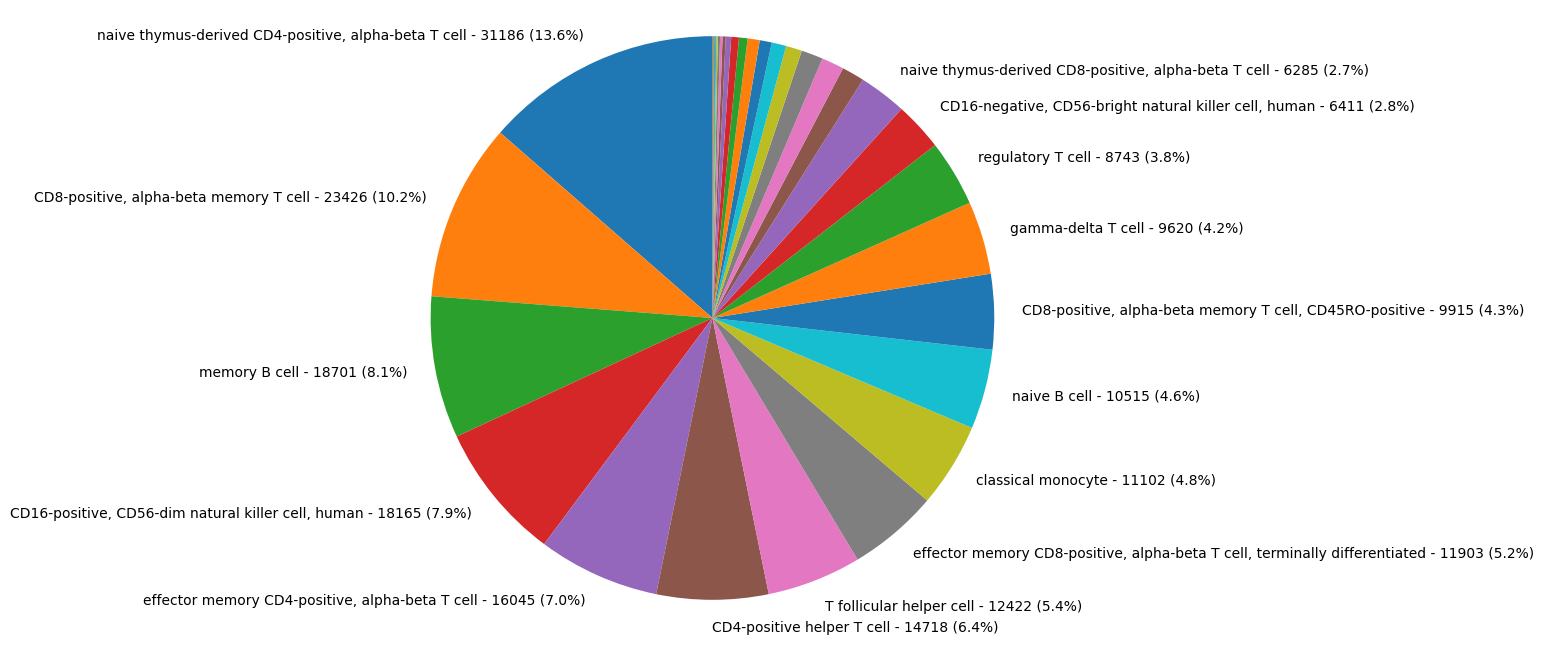

In [13]:
counts = all_labels.value_counts()
percentages = 100 * counts / counts.sum()
labels = [f'{index} - {count} ({percent:.1f}%)' if percent > 2 else '' for index, count, percent in zip(counts.index, counts, percentages)]

# Plot
plt.figure(figsize=(8, 8))
patches, texts = plt.pie(counts, labels=labels, startangle=90)

# plt.legend(patches, labels, title="Cell Types", loc="best")
plt.ylabel('')  # Remove the y-label as it's typically not needed for pie charts
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [14]:
# Cell Type Label Dict
cell_types = all_labels.value_counts().index.tolist()
label_dict = {cell_type: index for index, cell_type in enumerate(cell_types)}
label_dict

{'naive thymus-derived CD4-positive, alpha-beta T cell': 0,
 'CD8-positive, alpha-beta memory T cell': 1,
 'memory B cell': 2,
 'CD16-positive, CD56-dim natural killer cell, human': 3,
 'effector memory CD4-positive, alpha-beta T cell': 4,
 'CD4-positive helper T cell': 5,
 'T follicular helper cell': 6,
 'effector memory CD8-positive, alpha-beta T cell, terminally differentiated': 7,
 'classical monocyte': 8,
 'naive B cell': 9,
 'CD8-positive, alpha-beta memory T cell, CD45RO-positive': 10,
 'gamma-delta T cell': 11,
 'regulatory T cell': 12,
 'CD16-negative, CD56-bright natural killer cell, human': 13,
 'naive thymus-derived CD8-positive, alpha-beta T cell': 14,
 'mucosal invariant T cell': 15,
 'mast cell': 16,
 'alpha-beta T cell': 17,
 'animal cell': 18,
 'alveolar macrophage': 19,
 'macrophage': 20,
 'plasma cell': 21,
 'lymphocyte': 22,
 'group 3 innate lymphoid cell': 23,
 'non-classical monocyte': 24,
 'progenitor cell': 25,
 'conventional dendritic cell': 26,
 'plasmablast':

## Save Files

In [22]:
for dataset in tqdm(data, desc="Processing datasets"):
    dataset['cell_id'] = dataset['cell_type'].map(label_dict)

Processing datasets:   0%|          | 0/6 [00:00<?, ?it/s]/scratch/slurm-879467/ipykernel_19036/1612898548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cell_id'] = dataset['cell_type'].apply(lambda x: 0 if x == 'classical monocyte' else 1)
/scratch/slurm-879467/ipykernel_19036/1612898548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cell_id'] = dataset['cell_type'].apply(lambda x: 0 if x == 'classical monocyte' else 1)
/scratch/slurm-879467/ipykernel_19036/1612898548.py:3: Set

In [23]:
data[0]

,input_ids,cell_type,ensembl
0,"[MALAT1, RPLP1, EEF1A1, B2M, RPS27, RPS19, RPL...",CD4-positive helper T cell,ENSG00000251562 ENSG00000137818 ENSG0000015650...
1,"[B2M, MALAT1, RPL41, ACTB, TMSB4X, HLA-B, EEF1...",gamma-delta T cell,ENSG00000166710 ENSG00000251562 ENSG0000022911...
2,"[B2M, MALAT1, TMSB4X, ACTB, NKG7, RPLP1, HLA-B...","CD16-positive, CD56-dim natural killer cell, h...",ENSG00000166710 ENSG00000251562 ENSG0000020554...
3,"[B2M, ACTB, MALAT1, GNLY, TMSB4X, NKG7, MT-CO2...","CD16-positive, CD56-dim natural killer cell, h...",ENSG00000166710 ENSG00000196604 ENSG0000025156...
4,"[MALAT1, RPS27, MT-CO2, EEF1A1, MT-ND4L, B2M, ...","CD8-positive, alpha-beta memory T cell, CD45RO...",ENSG00000251562 ENSG00000177954 ENSG0000019871...
...,...,...,...
43742,"[MALAT1, MT-CO1, EEF1A1, HSP90AA1, MT-CO2, RPL...",gamma-delta T cell,ENSG00000251562 ENSG00000198804 ENSG0000015650...
43743,"[MT-CO1, RPLP1, MALAT1, RPS12, EEF1A1, FTH1, J...",gamma-delta T cell,ENSG00000198804 ENSG00000137818 ENSG0000025156...
43744,"[MALAT1, EEF1A1, ZFP36, RPL41, B2M, FOS, JUND,...",T follicular helper cell,ENSG00000251562 ENSG00000156508 ENSG0000012801...
43745,"[MT-CO1, EEF1A1, HLA-B, MALAT1, RPL41, RPLP1, ...","CD16-negative, CD56-bright natural killer cell...",ENSG00000198804 ENSG00000156508 ENSG0000023212...


In [20]:
train = pd.concat(data[:4])[["ensembl", "cell_id"]]
test = data[5][["ensembl", "cell_id"]]
val = data[5][["ensembl", "cell_id"]]

train.to_csv('immune-c2s/train.csv', header=False, index=False)
test.to_csv('immune-c2s/test.csv', header=False, index=False)
val.to_csv('immune-c2s/val.csv', header=False, index=False)

KeyError: "['cell_id'] not in index"

In [192]:
with open("immune-c2s/label_dictionary.pkl", 'wb') as file:
    pickle.dump(label_dict, file)

### Binary

In [33]:
for i in tqdm(range(len(data)), desc="Processing datasets"):
    data[i] = data[i].loc[data[i]['cell_type'].isin(['classical monocyte', 'memory B cell'])]
    data[i]['cell_id'] = data[i]['cell_type'].apply(lambda x: 0 if x == 'memory B cell' else 1)

Processing datasets: 100%|██████████| 6/6 [00:00<00:00, 567.10it/s]


In [34]:
train = pd.concat(data[:4])[["ensembl", "cell_id"]]
test = data[5][["ensembl", "cell_id"]]
val = data[5][["ensembl", "cell_id"]]

train.to_csv('immune-c2s/train-binary.csv', header=False, index=False)
test.to_csv('immune-c2s/test-binary.csv', header=False, index=False)
val.to_csv('immune-c2s/val-binary.csv', header=False, index=False)

In [36]:
# Cell Type Label Dict
# Store all unique cell types
all_labels = []

for dataset in tqdm(data, desc="Processing datasets"):
    all_labels.extend([label for label in dataset['cell_type']])

all_labels = pd.Series(all_labels)

cell_types = all_labels.value_counts().index.tolist()
label_dict = {cell_type: index for index, cell_type in enumerate(cell_types)}
label_dict

Processing datasets: 100%|██████████| 6/6 [00:00<00:00, 3860.97it/s]


{'memory B cell': 0, 'classical monocyte': 1}

In [37]:
with open("immune-c2s/label_binary_dictionary.pkl", 'wb') as file:
    pickle.dump(label_dict, file)